# Часть 2: методы оценки Value-at-Risk

### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import math
import random

import datetime
from datetime import datetime

from copy import copy, deepcopy

import sys
import warnings
import os

In [2]:
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm, skewnorm, gennorm, t, nct, genpareto, genextreme, genhyperbolic, chi2, ncx2
from scipy.stats import skew, kurtosis

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
folder = '/content/drive/MyDrive/Kagan_VKR/'

folder_dict = {'IMOEX': '1_imoex',
               'BCOMCO': '2_bcomco',
               'EUR_RUB': '4_euro',
               'Газпром': '5_gazprom'}

In [7]:
# модуль для оценки Value-at_risk, реализованный в рамках ВКР
from var_calculation import VaR_calculation

# модуль для отрисовки результатов бэктестирования Value-at_risk, реализованный в рамках ВКР
from var_visual import VAR_visualisation

### Данные

In [8]:
if 'price_data.xlsx' in os.listdir(folder+'/data'):
    df_price = pd.read_excel(folder+'data/price_data.xlsx')
    df_price.set_index('Date', inplace=True)
else:
    print('Файл с данными не обнаружен!')

In [9]:
all_columns = df_price.columns
print(all_columns)

Index(['EUR_RUB', 'USD_RUB', 'BCOMCO', 'IMOEX', 'Газпром'], dtype='object')


In [10]:
def calculate_returns(df, name):
    df_1 = df[name].dropna()
    return df_1.pct_change().dropna()

In [11]:
window_list = [250, 500, 750, 1000, 1250]

freq_list = [5, 25, 50, 100, 150, 200]

In [12]:
def calculate_var(name, returns, file_name, models=None, window_lst=None, freq_lst=None):
    window_lst = window_list if window_lst is None else window_lst
    freq_lst = freq_list if freq_lst is None else freq_lst

    res = pd.DataFrame()
    var_obj = VaR_calculation(returns=returns, name=name)
    for w in window_lst:
        for f in freq_lst:
            df_cur = var_obj.backtest(window_size=w, recalibration_freq=f, models=models, return_=1)
            df_cur['Window'] = [w] * df_cur.shape[0]
            df_cur['Frequency'] = [f] * df_cur.shape[0]
            res = pd.concat([res, df_cur])

    name_for_save = f"/{name}_{file_name}.xlsx"
    res.to_excel(folder+folder_dict[name]+name_for_save)

In [13]:
def download_data(name, file_name):
    d = pd.read_excel(folder+folder_dict[name]+f"/{name}_{file_name}.xlsx")
    d.set_index('Date', inplace=True)
    return d

# Value-at-Risk

## BCOMCO

In [ ]:
# Вычисление

warnings.filterwarnings("ignore")

oil = calculate_returns(df=df_price, name='BCOMCO')
calculate_var(name='BCOMCO', returns=oil, file_name='final')

In [ ]:
# Загрузка вычисленных ранее результатов

df_brent = download_data('BCOMCO', file_name='final')

In [ ]:
oil_res = VAR_visualisation(name='BCOMCO', df_var=df_brent)

#### Параметры

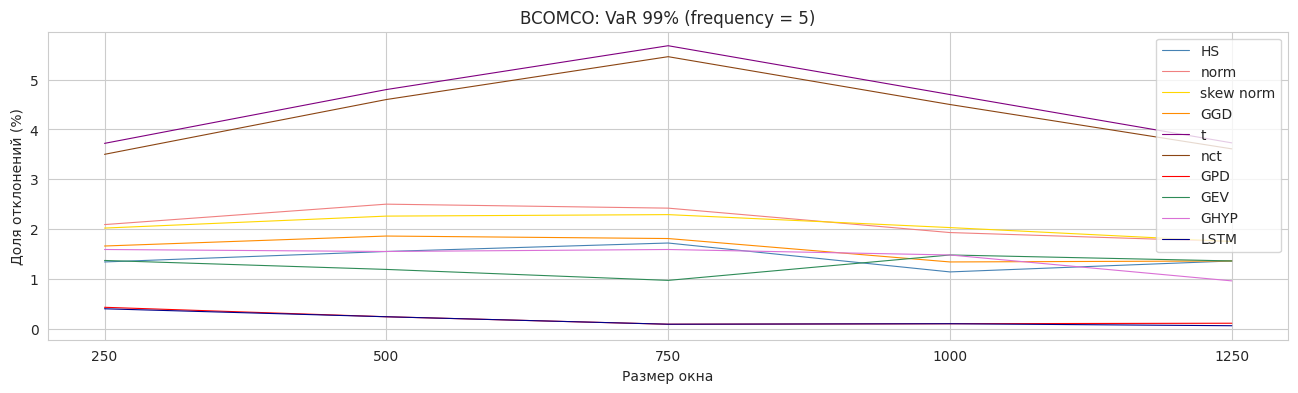

In [ ]:
oil_res.plot_parametr_window(freq=5)

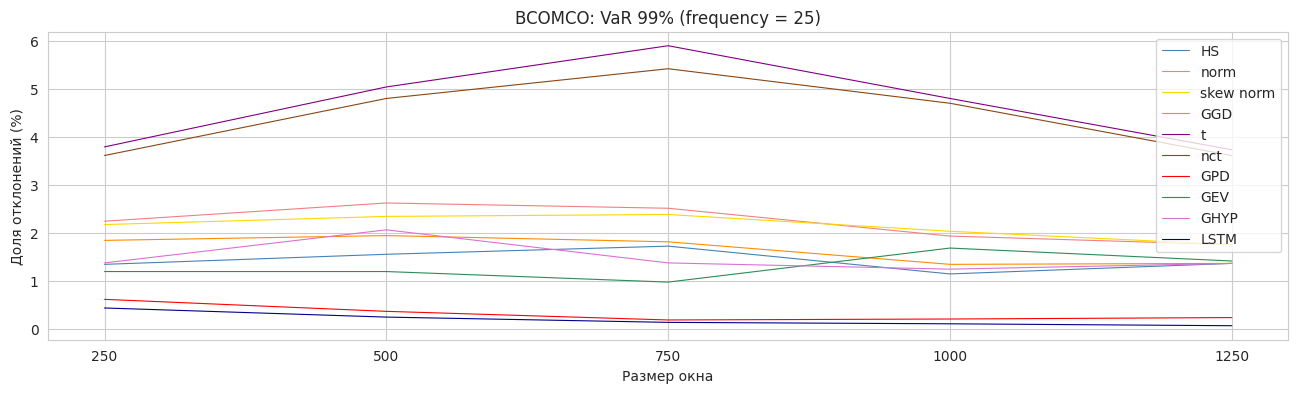

In [ ]:
oil_res.plot_parametr_window(freq=25)

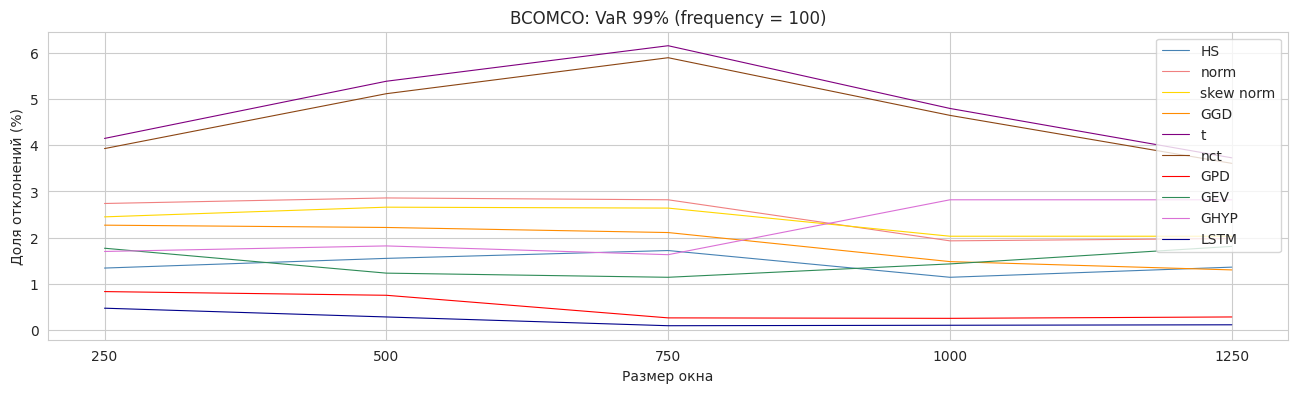

In [ ]:
oil_res.plot_parametr_window(freq=100)

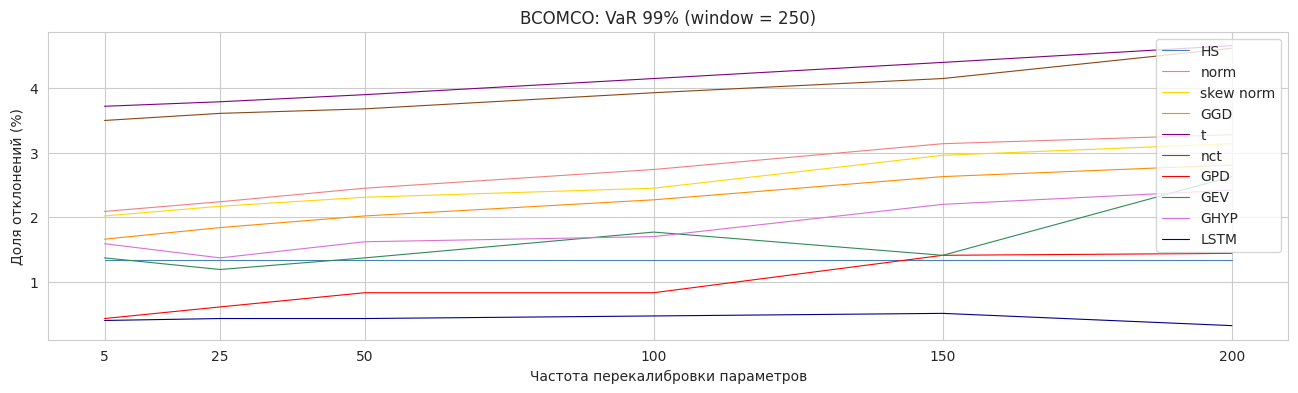

In [ ]:
oil_res.plot_parametr_frequency(window=250)

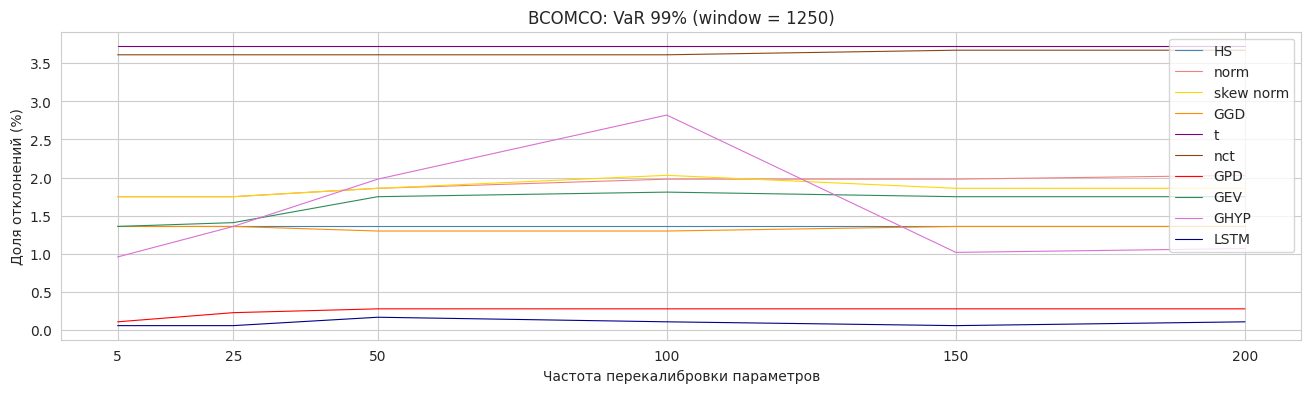

In [ ]:
oil_res.plot_parametr_frequency(window=1250)

Для распределения Стьюдента и нецентрального распределения Стьюдента доля отклонений значительно отличается от нужного уровня при людом наборе параметров. Обобщенное распределение Парето и LSTM, наоборот, переоценивают риски.

Оценим визуально изменение результатов бэктеста для одной модели в зависимости от одного из параметров при фиксировании другого.

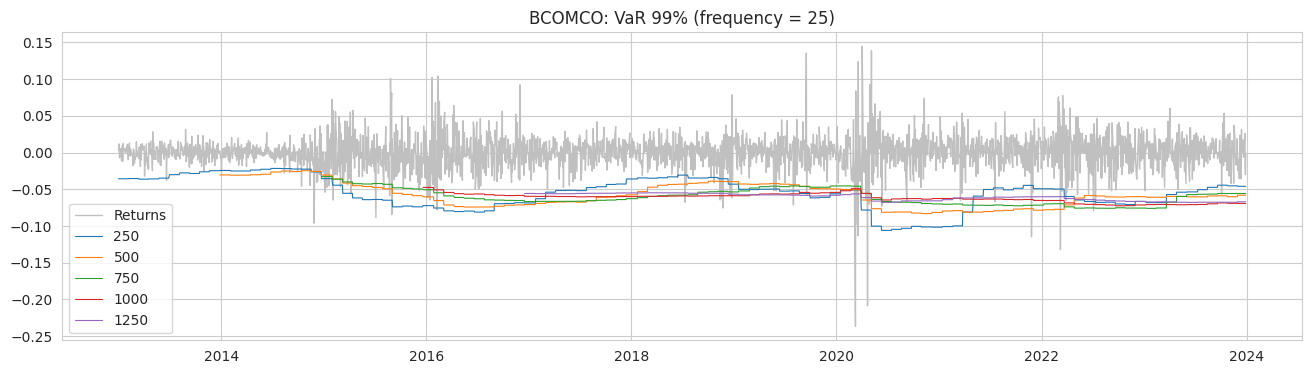

In [ ]:
oil_res.plot_parametr_backtest(model='GGD', parametr='window', freq=25)

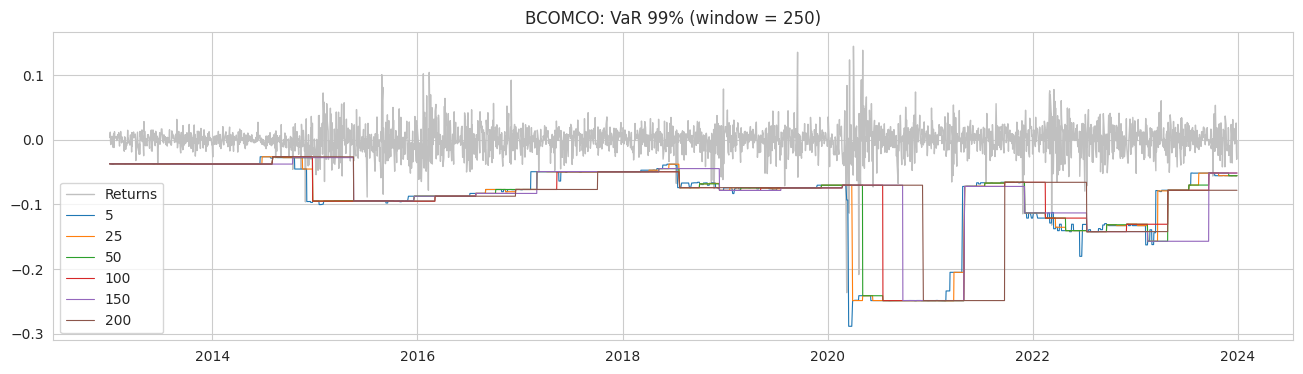

In [ ]:
oil_res.plot_parametr_backtest(model='GPD', parametr='frequency', window=250)

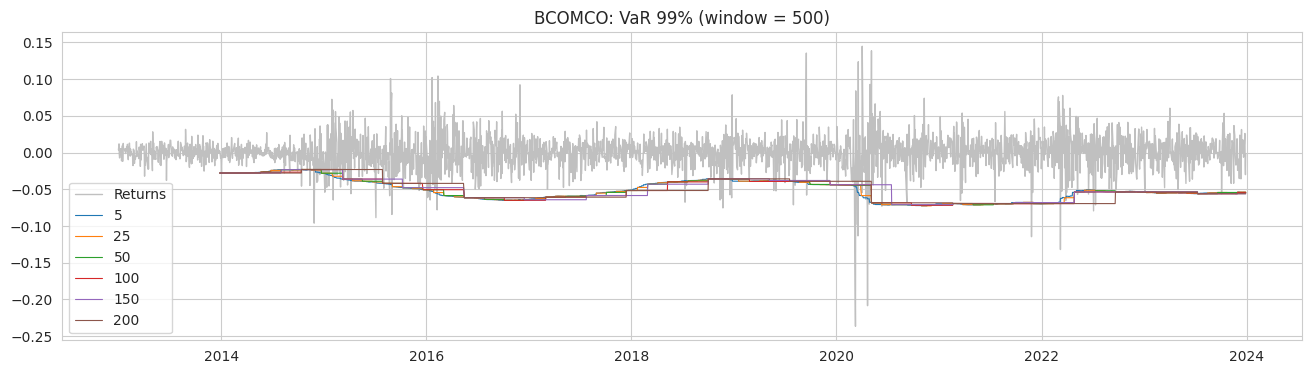

In [ ]:
oil_res.plot_parametr_backtest(model='norm', parametr='frequency', window=500)

#### Тесты

In [ ]:
oil_res.get_backtest_results()

Доля отклонений (%) 



Исторический метод  Нормальное распределение  \
Window Freq                                                 
250    5                   1.34                      2.09   
       25                  1.34                      2.24   
       50                  1.34                      2.45   
       100                 1.34                      2.74   
       150                 1.34                      3.14   
       200                 1.34                      3.28   
500    5                   1.55                      2.50   
       25                  1.55                      2.62   
       50                  1.55                      2.74   
       100                 1.55                      2.86   
       150                 1.55                      3.01   
       200                 1.55                      3.33   
750    5                   1.72                      2.42   
       25                  1.72                      2.51   
       50                  1.72                      2.64   
       100                 1.72                      2.82   
       150                 1.72                      2.82   
       200                 1.72                      3.08   
1000   5                   1.14                      1.93   
       25                  1.14                      1.93   
       50                  1.14                      1.93   
       100                 1.14                      1.93   
       150                 1.14                      2.08   
       200                 1.14                      2.08   
1250   5                   1.36                      1.75   
       25                  1.36                      1.75   
       50                  1.36                      1.86   
       100                 1.36                      1.98   
       150                 1.36                      1.98   
       200                 1.36                      2.03   

             Скошенное нормальное распределение  \
Window Freq                                       
250    5                                   2.02   
       25                                  2.17   
       50                                  2.31   
       100                                 2.45   
       150                                 2.96   
       200                                 3.14   
500    5                                   2.26   
       25                                  2.34   
       50                                  2.42   
       100                                 2.66   
       150                                 2.78   
       200                                 2.98   
750    5                                   2.29   
       25                                  2.38   
       50                                  2.47   
       100                                 2.64   
       150                                 2.60   
       200                                 2.91   
1000   5                                   2.03   
       25                                  2.03   
       50                                  2.03   
       100                                 2.03   
       150                                 2.13   
       200                                 2.13   
1250   5                                   1.75   
       25                                  1.75   
       50                                  1.86   
       100                                 2.03   
       150                                 1.86   
       200                                 1.86   

             Обобщенное нормальное распределение  Распределение Стьюдента  \
Window Freq                                                                 
250    5                                    1.66                     3.72   
       25                                   1.84                     3.79   
       50                                   2.02                     3.90   
       100                                

In [ ]:
oil_res.test_kupiec_all()

In [ ]:
oil_res.test_christoffersen_all()

#### Результаты

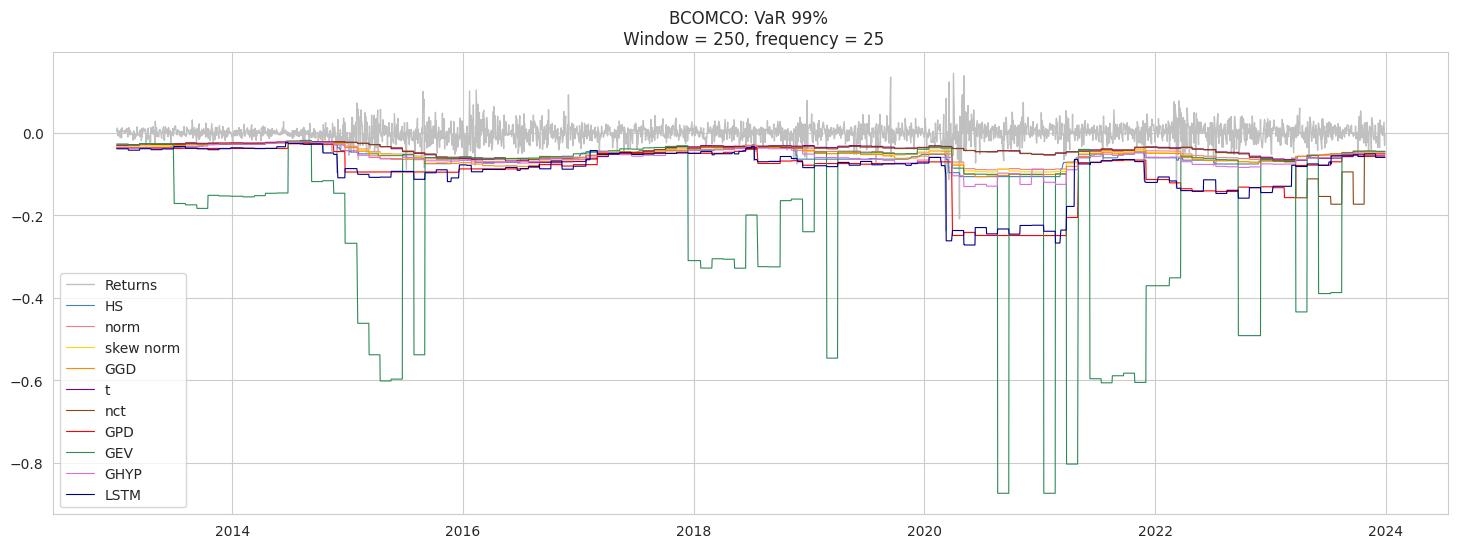

In [ ]:
oil_res.plot_backtest(window=250, freq=25)

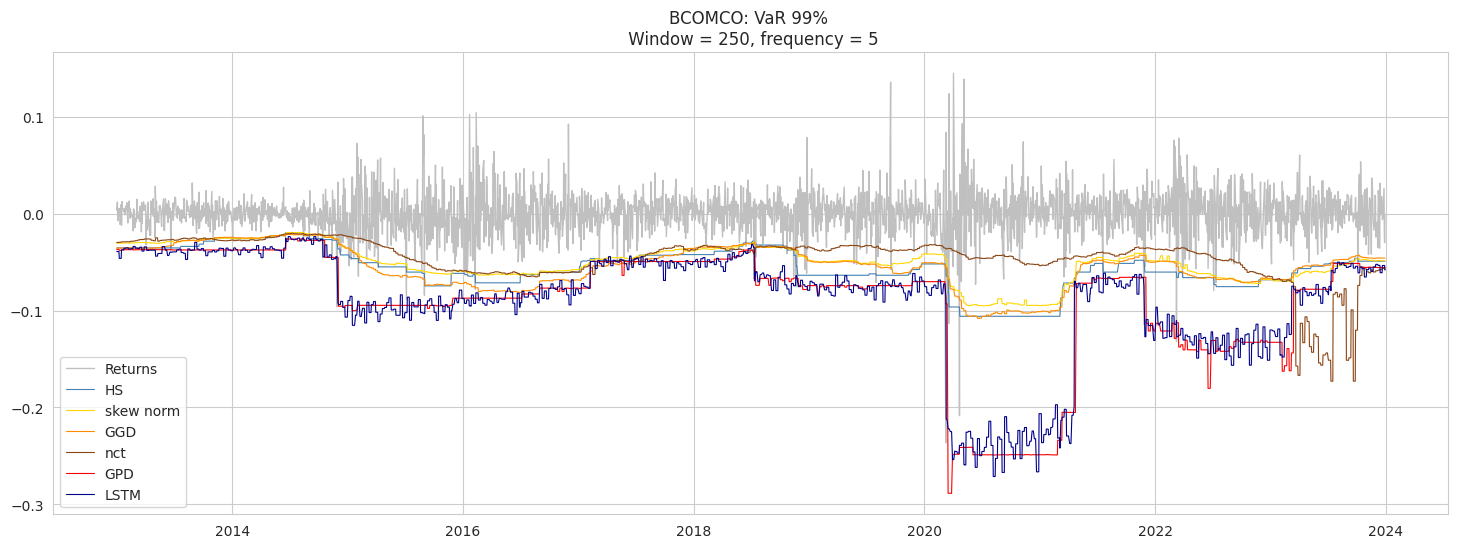

In [ ]:
oil_res.plot_backtest(window=250, freq=5, models=['HS', 'skew norm', 'GGD', 'nct', 'GPD', 'LSTM'])

Посмотрим на коротком интервале времени, как быстро модели реагируют на изменения и экстремальные значения в динамике доходностей.

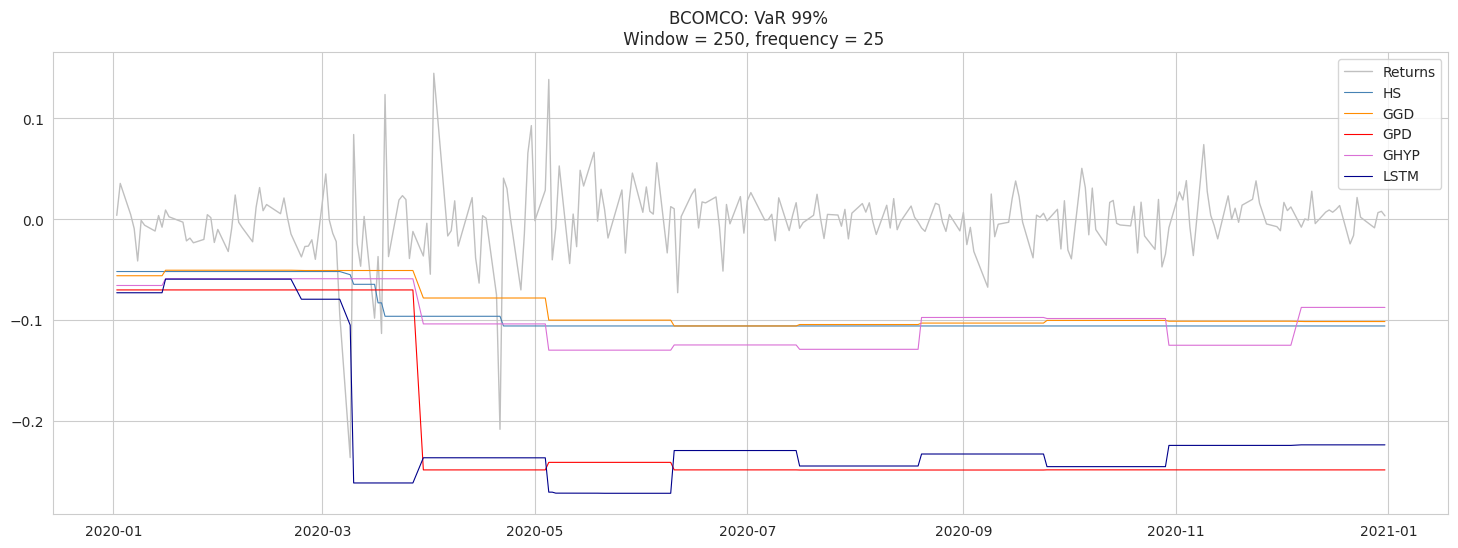

In [ ]:
oil_res.plot_backtest(window=250, freq=25,
                      models=['HS', 'GGD', 'GPD', 'GHYP', 'LSTM'],
                      start_date='2020-01-01',
                      end_date='2020-12-31')

## Газпром

In [24]:
warnings.filterwarnings("ignore")

In [ ]:
# Вычисление

gazp = calculate_returns(df=df_price, name='Газпром')
calculate_var(name='Газпром', returns=gazp, file_name='final')

In [14]:
# Загрузка полученных результатов

df_gazp = download_data('Газпром', file_name='final')

In [15]:
gazp_res = VAR_visualisation(name='Газпром', df_var=df_gazp)

#### Параметры

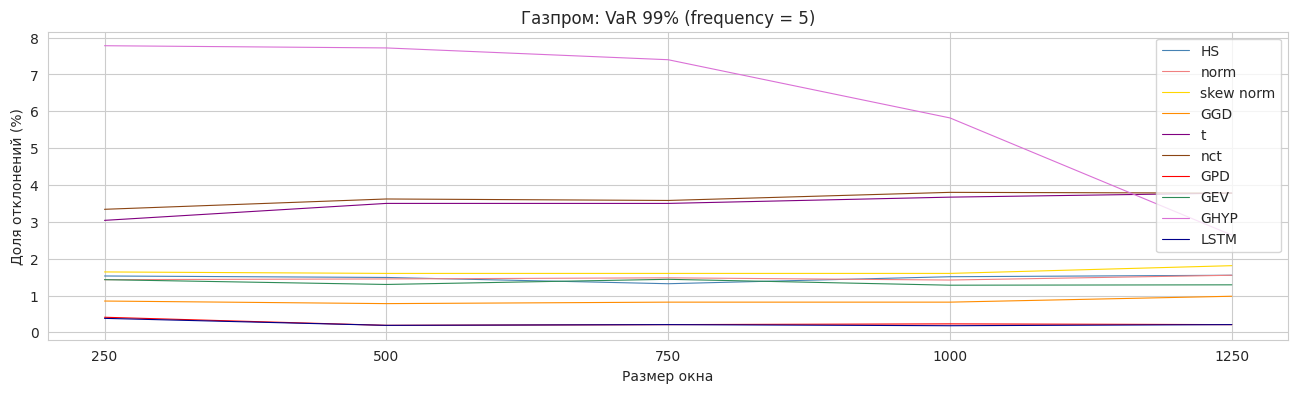

In [16]:
gazp_res.plot_parametr_window(freq=5)

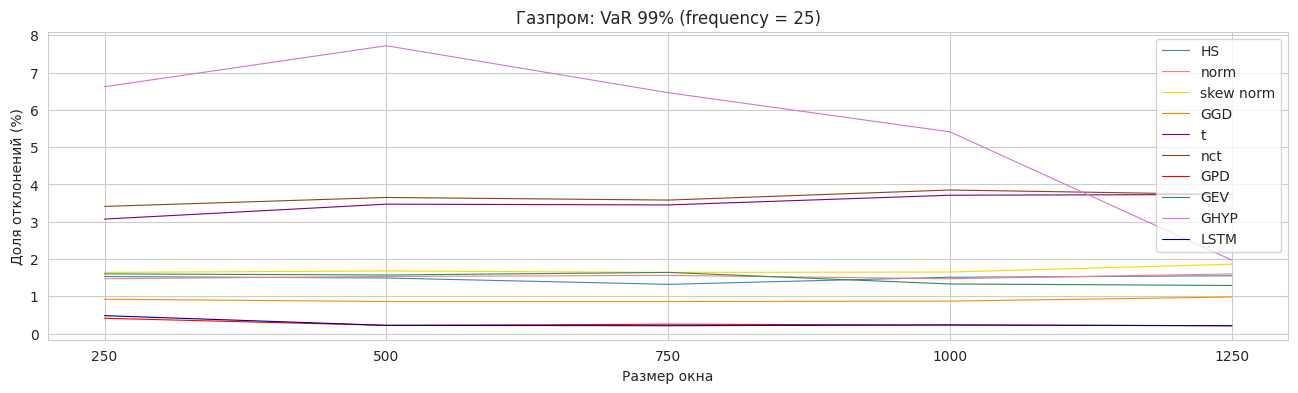

In [17]:
gazp_res.plot_parametr_window(freq=25)

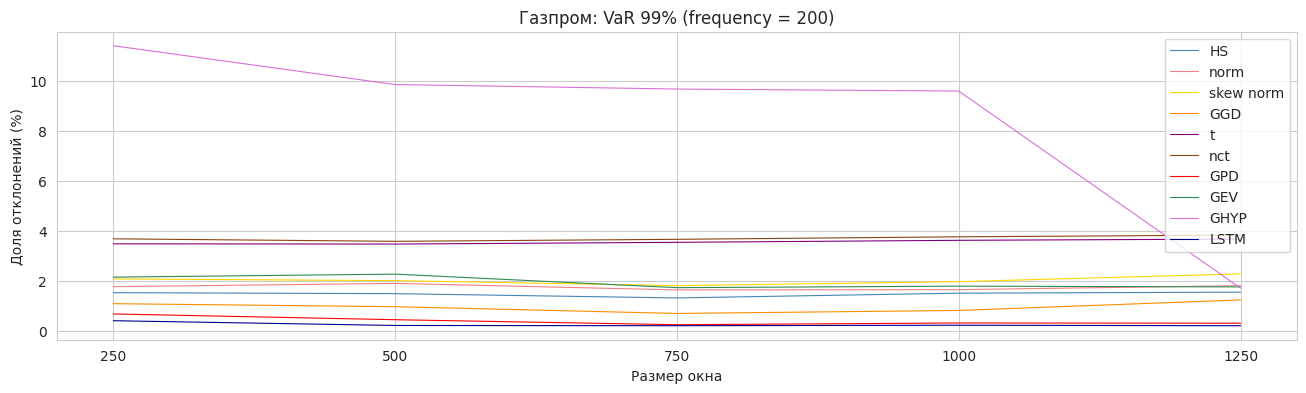

In [18]:
gazp_res.plot_parametr_window(freq=200)

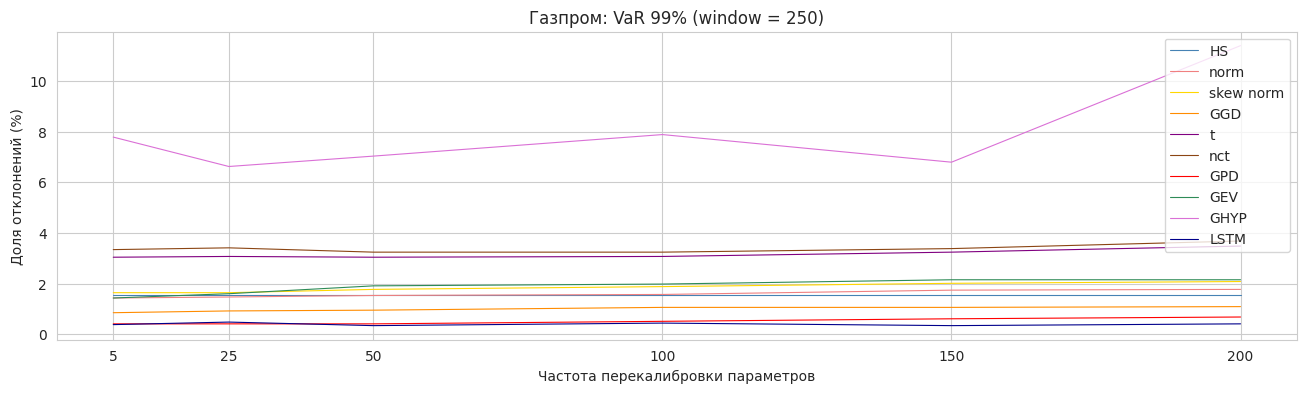

In [19]:
gazp_res.plot_parametr_frequency(window=250)

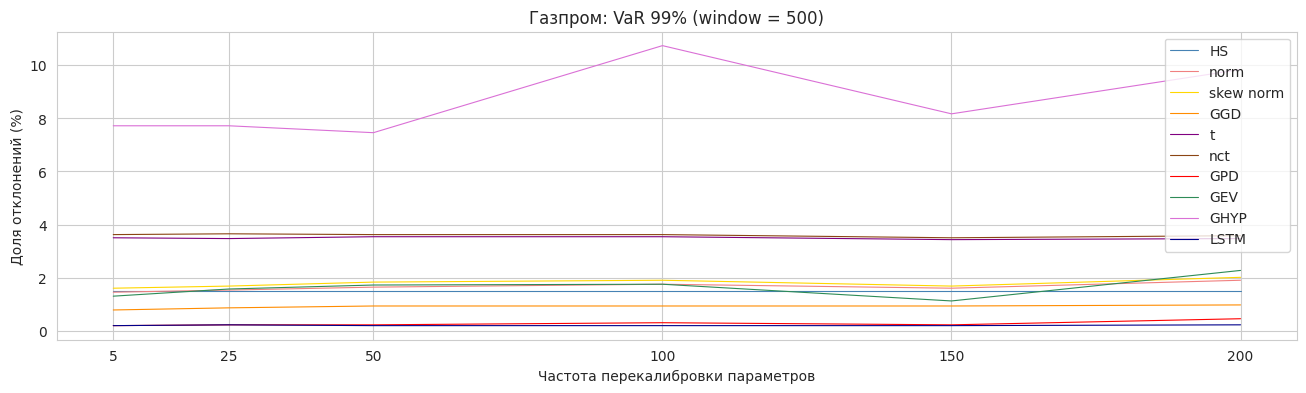

In [20]:
gazp_res.plot_parametr_frequency(window=500)

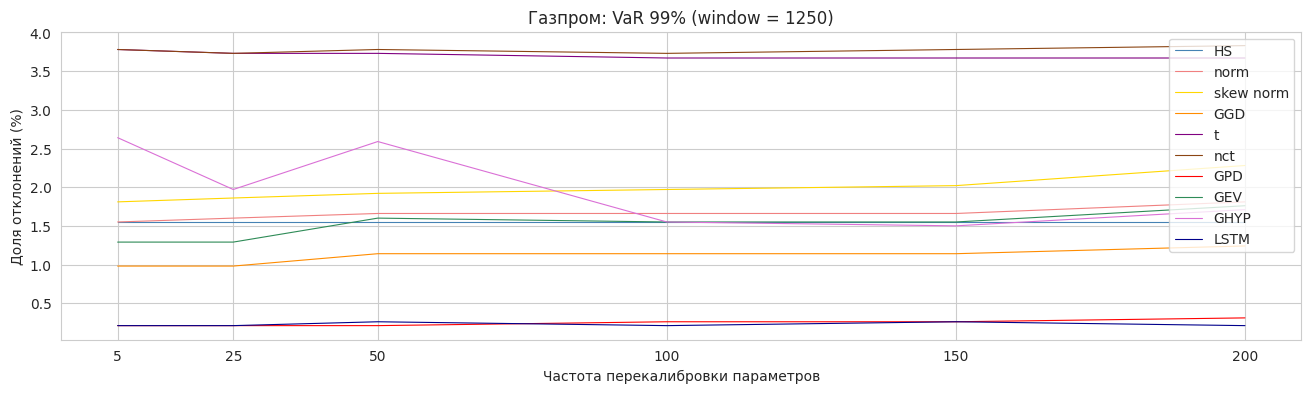

In [21]:
gazp_res.plot_parametr_frequency(window=1250)

Помимо распределения Стьюдента обобщенное гиперболическое распределение также значительно превышает ожидаемый уровень.

#### Тесты

In [22]:
gazp_res.get_backtest_results()

Доля отклонений (%) 



Исторический метод  Нормальное распределение  \
Window Freq                                                 
250    5                   1.53                      1.43   
       25                  1.53                      1.47   
       50                  1.53                      1.53   
       100                 1.53                      1.57   
       150                 1.53                      1.74   
       200                 1.53                      1.77   
500    5                   1.49                      1.45   
       25                  1.49                      1.53   
       50                  1.49                      1.64   
       100                 1.49                      1.75   
       150                 1.49                      1.60   
       200                 1.49                      1.90   
750    5                   1.32                      1.48   
       25                  1.32                      1.56   
       50                  1.32                      1.69   
       100                 1.32                      1.64   
       150                 1.32                      1.77   
       200                 1.32                      1.64   
1000   5                   1.51                      1.42   
       25                  1.51                      1.47   
       50                  1.51                      1.65   
       100                 1.51                      1.70   
       150                 1.51                      1.65   
       200                 1.51                      1.65   
1250   5                   1.55                      1.55   
       25                  1.55                      1.60   
       50                  1.55                      1.66   
       100                 1.55                      1.66   
       150                 1.55                      1.66   
       200                 1.55                      1.81   

             Скошенное нормальное распределение  \
Window Freq                                       
250    5                                   1.64   
       25                                  1.64   
       50                                  1.77   
       100                                 1.88   
       150                                 2.01   
       200                                 2.08   
500    5                                   1.60   
       25                                  1.68   
       50                                  1.83   
       100                                 1.90   
       150                                 1.68   
       200                                 2.01   
750    5                                   1.60   
       25                                  1.64   
       50                                  1.93   
       100                                 1.85   
       150                                 1.97   
       200                                 1.81   
1000   5                                   1.60   
       25                                  1.65   
       50                                  1.88   
       100                                 1.97   
       150                                 1.92   
       200                                 1.97   
1250   5                                   1.81   
       25                                  1.86   
       50                                  1.92   
       100                                 1.97   
       150                                 2.02   
       200                                 2.28   

             Обобщенное нормальное распределение  Распределение Стьюдента  \
Window Freq                                                                 
250    5                                    0.85                     3.04   
       25                                   0.92                     3.07   
       50                                   0.95                     3.04   
       100                                

In [25]:
gazp_res.test_kupiec_all()

In [26]:
gazp_res.test_christoffersen_all()

#### Результаты

Посмотрим на результаты бэктеста с окном в год и минимальной частотой перекалибровки.

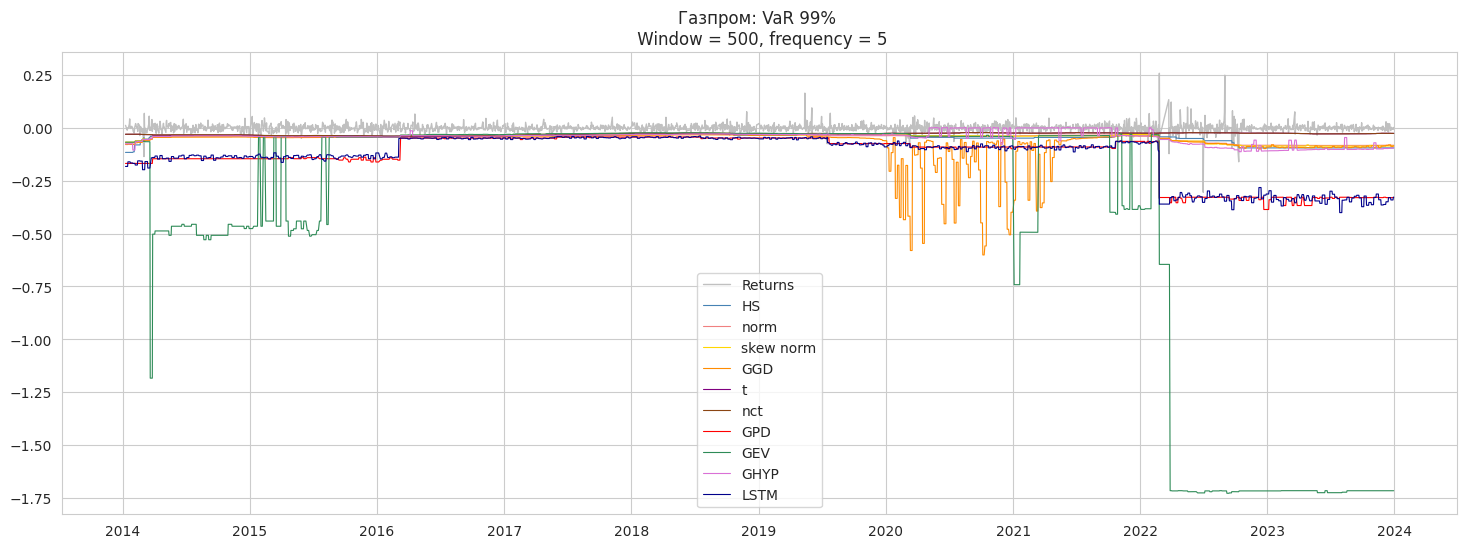

In [27]:
gazp_res.plot_backtest(window=500, freq=5)

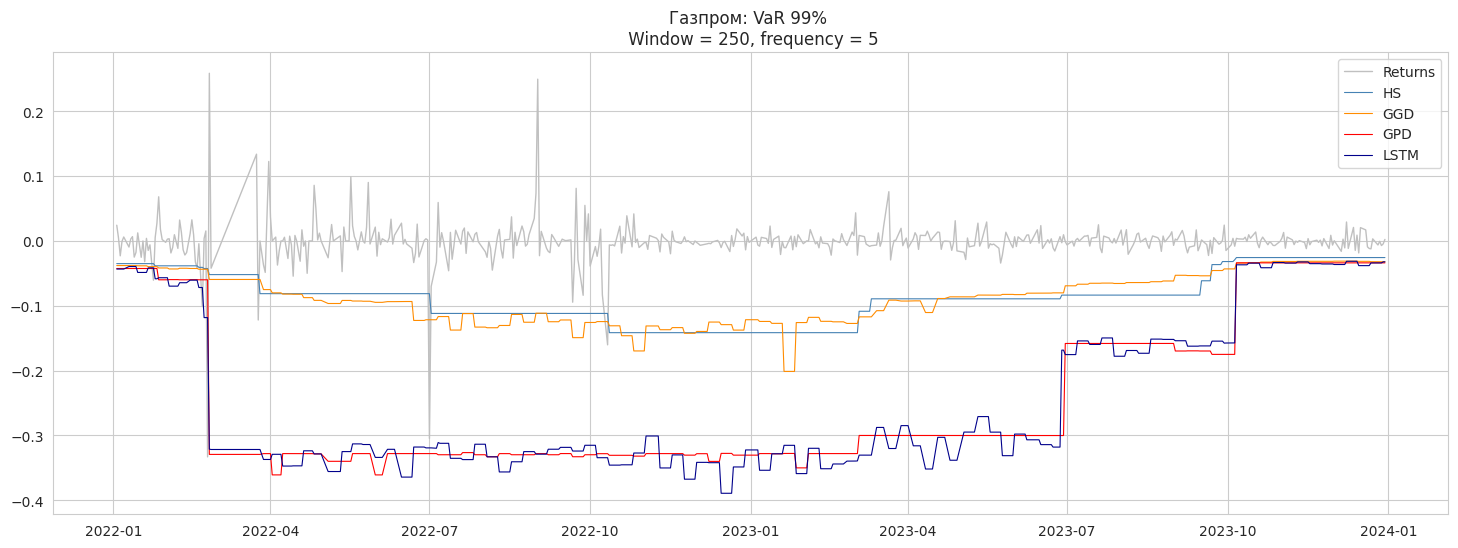

In [28]:
gazp_res.plot_backtest(window=250, freq=5,
                       models=['HS', 'GGD', 'GPD', 'LSTM'],
                       start_date = '2022-01-01')

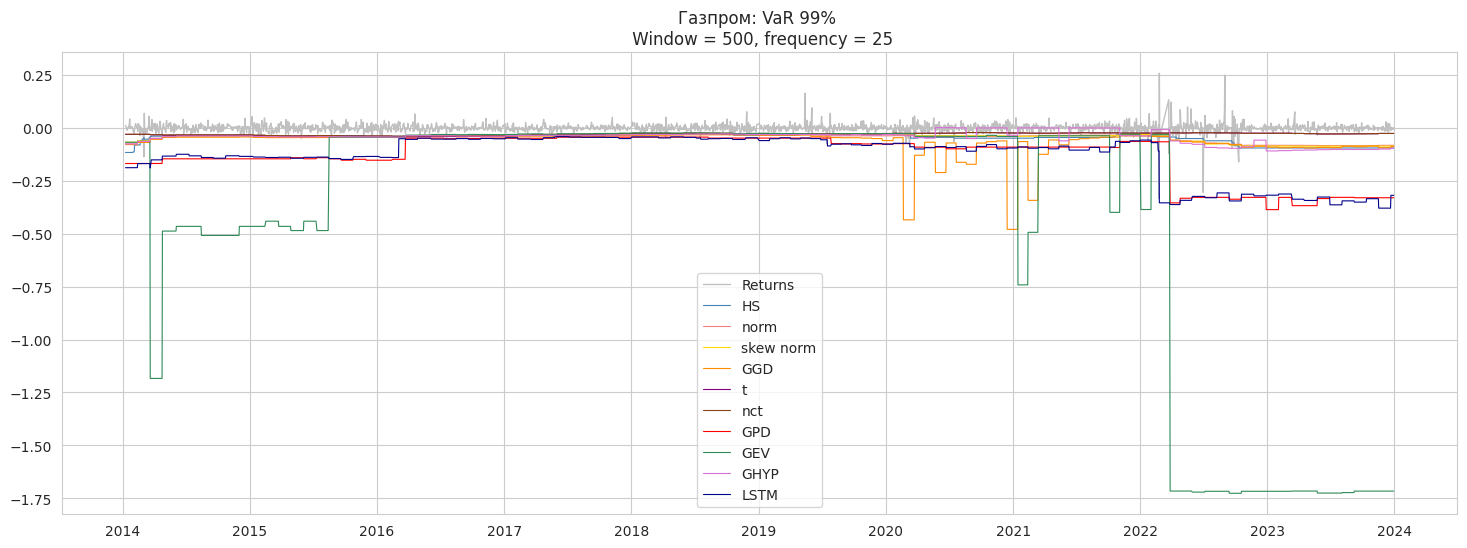

In [30]:
gazp_res.plot_backtest(window=500, freq=25)

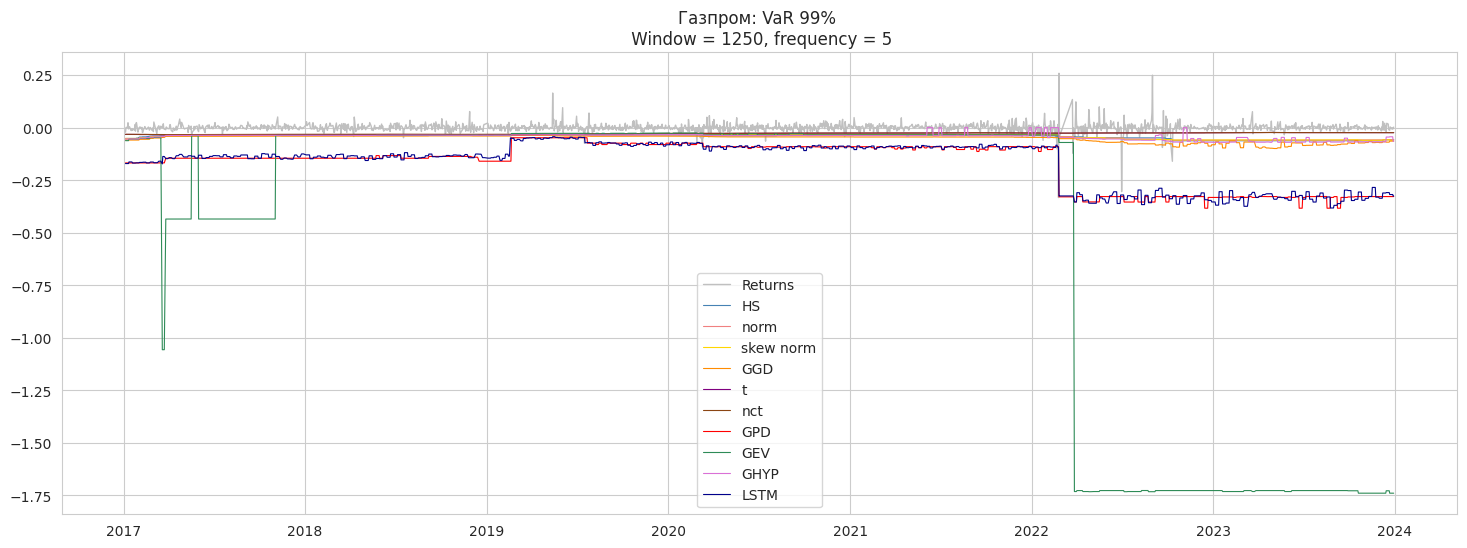

In [31]:
gazp_res.plot_backtest(window=1250, freq=5)

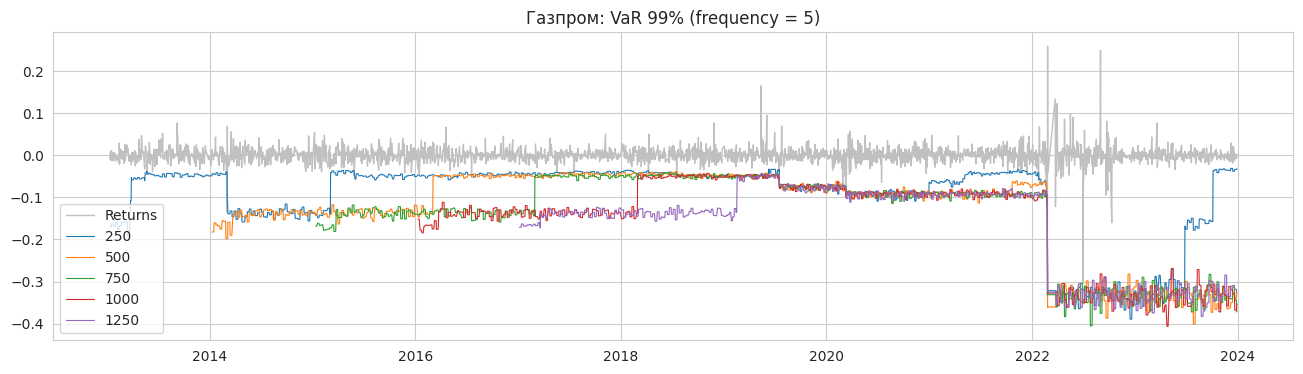

In [33]:
gazp_res.plot_parametr_backtest(model='LSTM', parametr='window', freq=5)

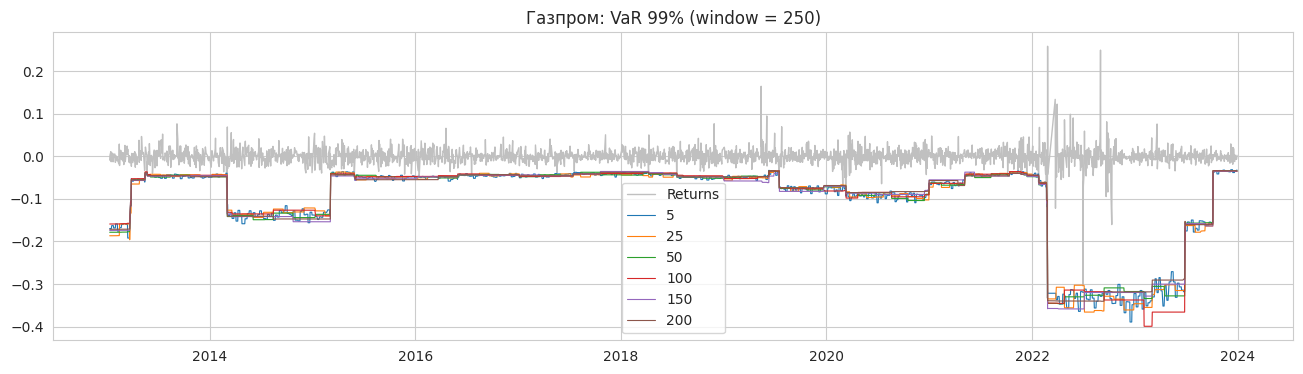

In [34]:
gazp_res.plot_parametr_backtest(model='LSTM', parametr='frequency', window=250)

## Курс евро

In [ ]:
euro = calculate_returns(df=df_price, name='EUR_RUB')

Так как на первых двух рядах убедились, что полезно рассматривать в основном случаи более частой перекалибровки, посчитаем только для частот 5, 25, 50.

In [ ]:
warnings.filterwarnings("ignore")

calculate_var(name='EUR_RUB', returns=euro, file_name='final',
              freq_lst=[5, 25, 50])

In [35]:
# Выгрузка результатов

df_euro = download_data('EUR_RUB', file_name='final')

In [36]:
euro_res = VAR_visualisation(name='EUR_RUB', df_var=df_euro)

#### Тесты

In [39]:
euro_res.get_backtest_results()

Доля отклонений (%) 



Исторический метод  Нормальное распределение  \
Window Freq                                                 
250    5                   1.43                      1.84   
       25                  1.43                      2.05   
       50                  1.43                      2.19   
500    5                   1.48                      1.48   
       25                  1.48                      1.56   
       50                  1.48                      1.83   
750    5                   1.64                      1.72   
       25                  1.64                      1.77   
       50                  1.64                      2.06   
1000   5                   1.46                      1.32   
       25                  1.46                      1.55   
       50                  1.46                      1.60   
1250   5                   1.33                      1.33   
       25                  1.33                      1.49   
       50                  1.33                      1.65   

             Скошенное нормальное распределение  \
Window Freq                                       
250    5                                   2.02   
       25                                  2.26   
       50                                  2.71   
500    5                                   1.75   
       25                                  1.90   
       50                                  2.28   
750    5                                   1.98   
       25                                  2.10   
       50                                  2.44   
1000   5                                   1.55   
       25                                  1.79   
       50                                  2.02   
1250   5                                   1.44   
       25                                  1.65   
       50                                  1.76   

             Обобщенное нормальное распределение  Распределение Стьюдента  \
Window Freq                                                                 
250    5                                    1.04                     5.11   
       25                                   1.11                     5.35   
       50                                   1.49                     5.49   
500    5                                    1.10                     6.09   
       25                                   1.26                     6.24   
       50                                   1.37                     6.36   
750    5                                    1.35                     6.86   
       25                                   1.43                     6.90   
       50                                   1.60                     6.90   
1000   5                                    1.36                     5.17   
       25                                   1.50                     5.22   
       50                                   1.65                     5.45   
1250   5                                    1.49                     4.69   
       25                                   1.60                     4.74   
       50                                   1.65                     4.90   

             Нецентральное распределение Стьюдента  \
Window Freq                                          
250    5                                      5.21   
       25                                     5.42   
       50                                     5.49   
500    5                                      6.13   
       25                                     6.24   
       50                                     6.55   
750    5                                      6.86   
       25                                     6.94   
       50                                     6.94   
1000   5                                      5.31   
       25                                     5.36   
       50                                     5.50   
1250   5                                 

In [37]:
euro_res.test_kupiec_all()

In [38]:
euro_res.test_christoffersen_all()

#### Параметры

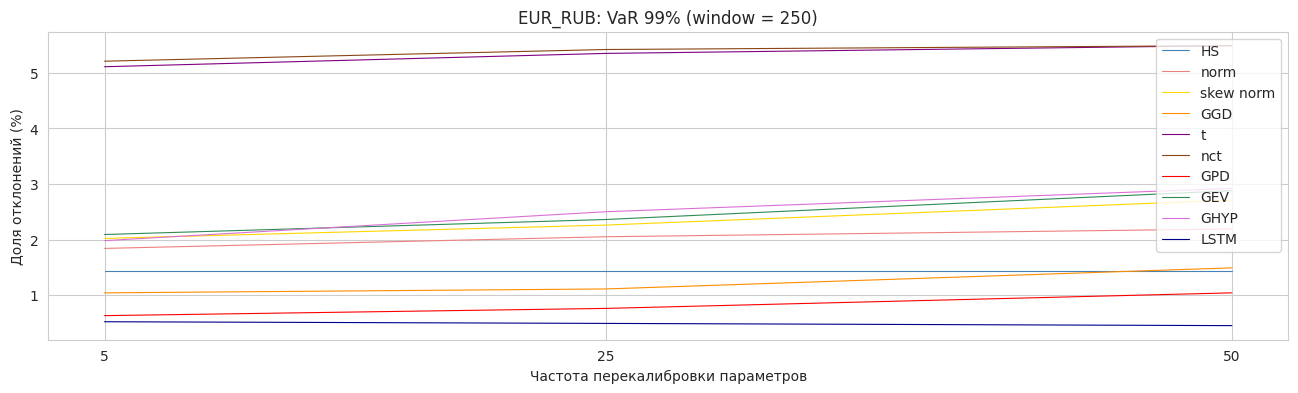

In [46]:
euro_res.plot_parametr_frequency(window=250)

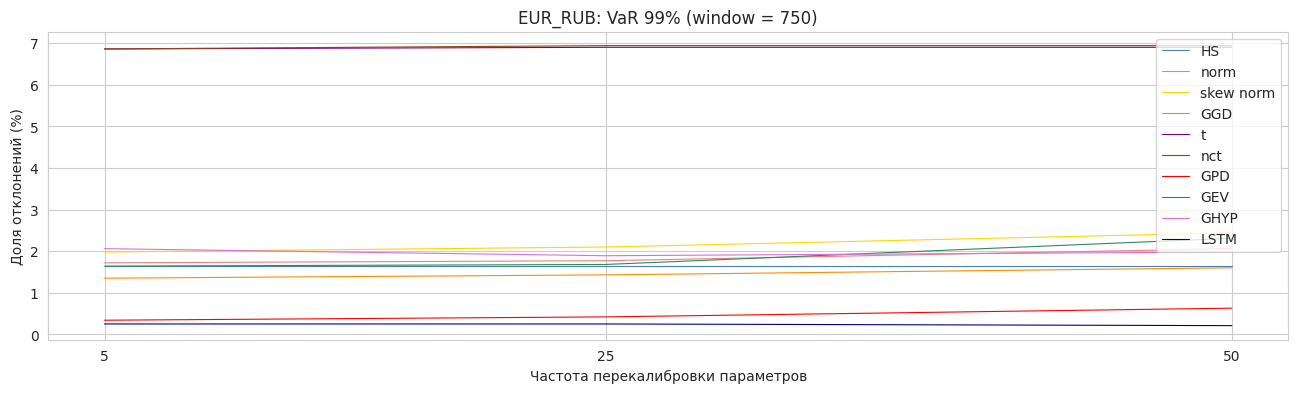

In [47]:
euro_res.plot_parametr_frequency(window=750)

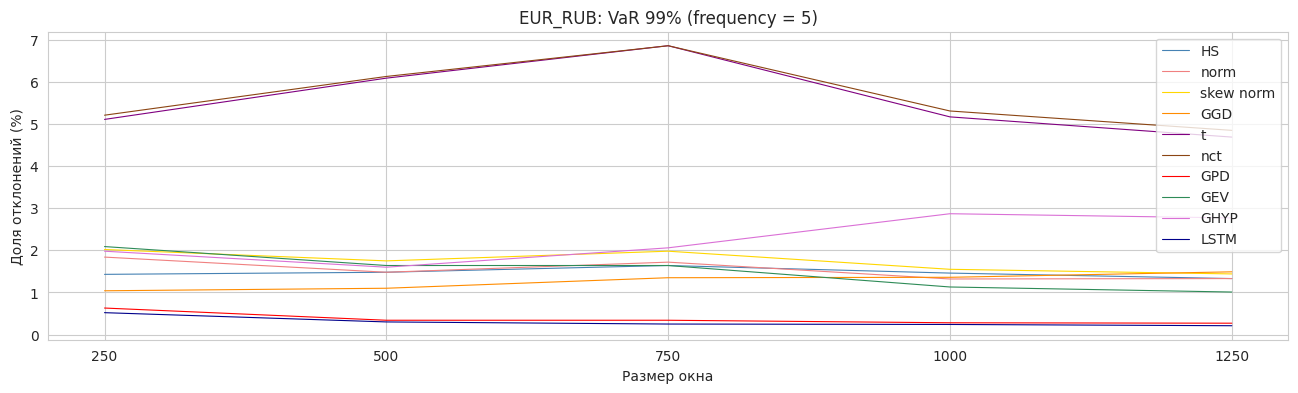

In [48]:
euro_res.plot_parametr_window(freq=5)

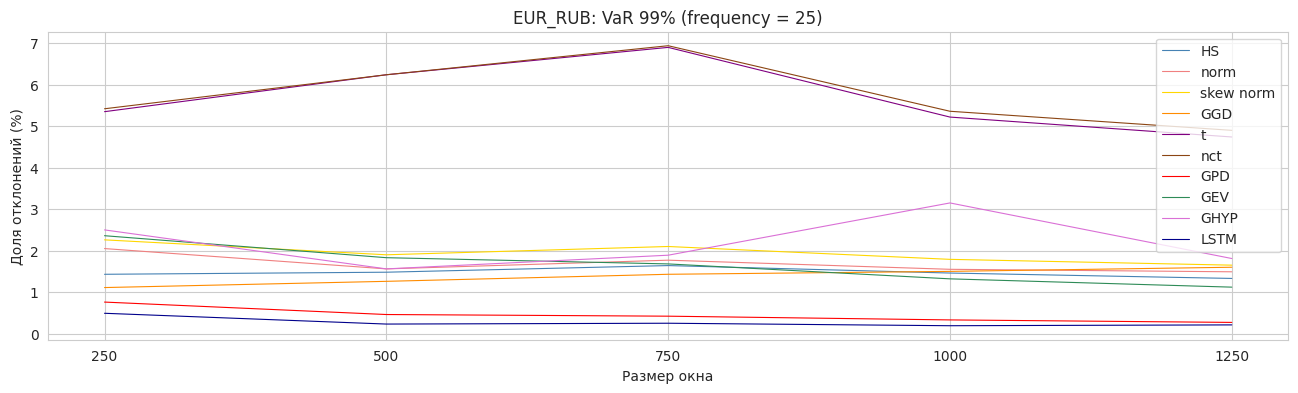

In [49]:
euro_res.plot_parametr_window(freq=25)

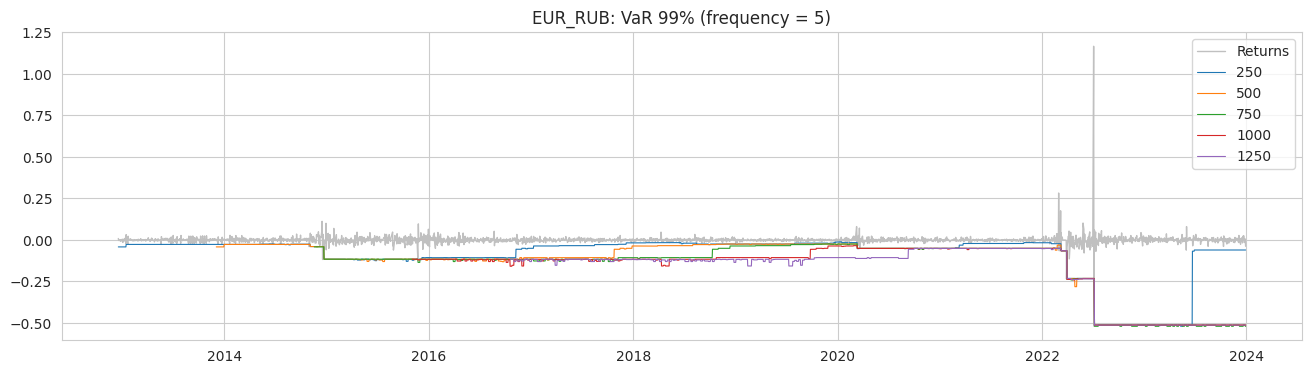

In [54]:
euro_res.plot_parametr_backtest(model='GPD', parametr='window', freq=5)

#### Результаты

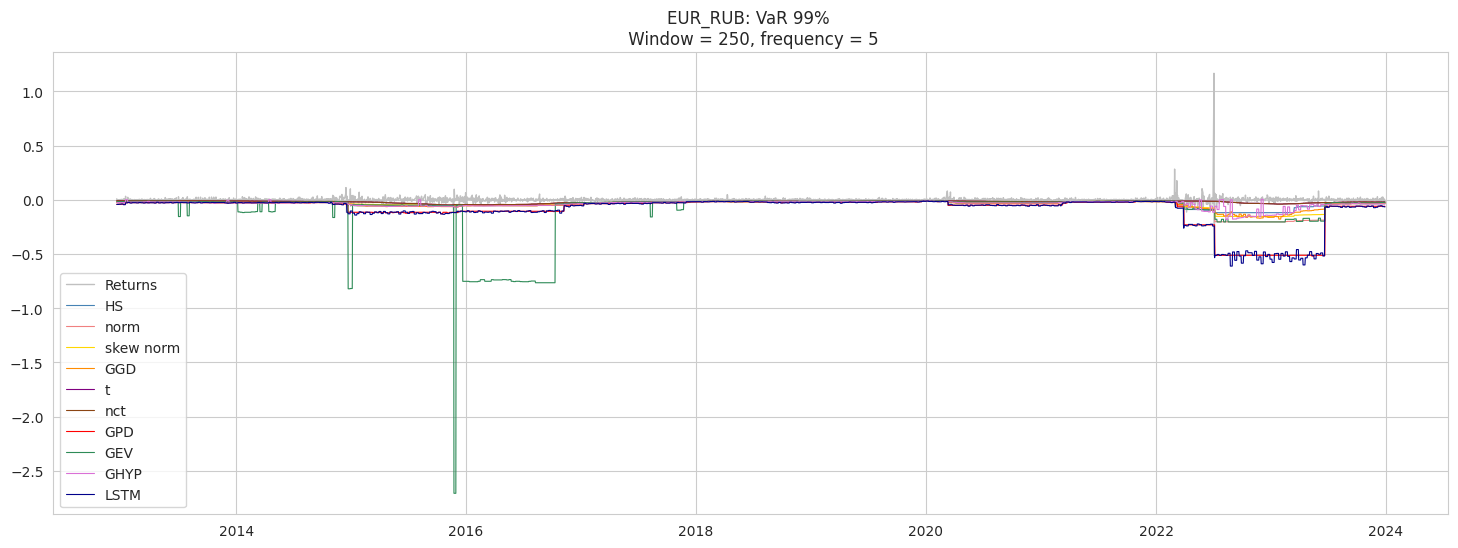

In [55]:
euro_res.plot_backtest(window=250, freq=5)

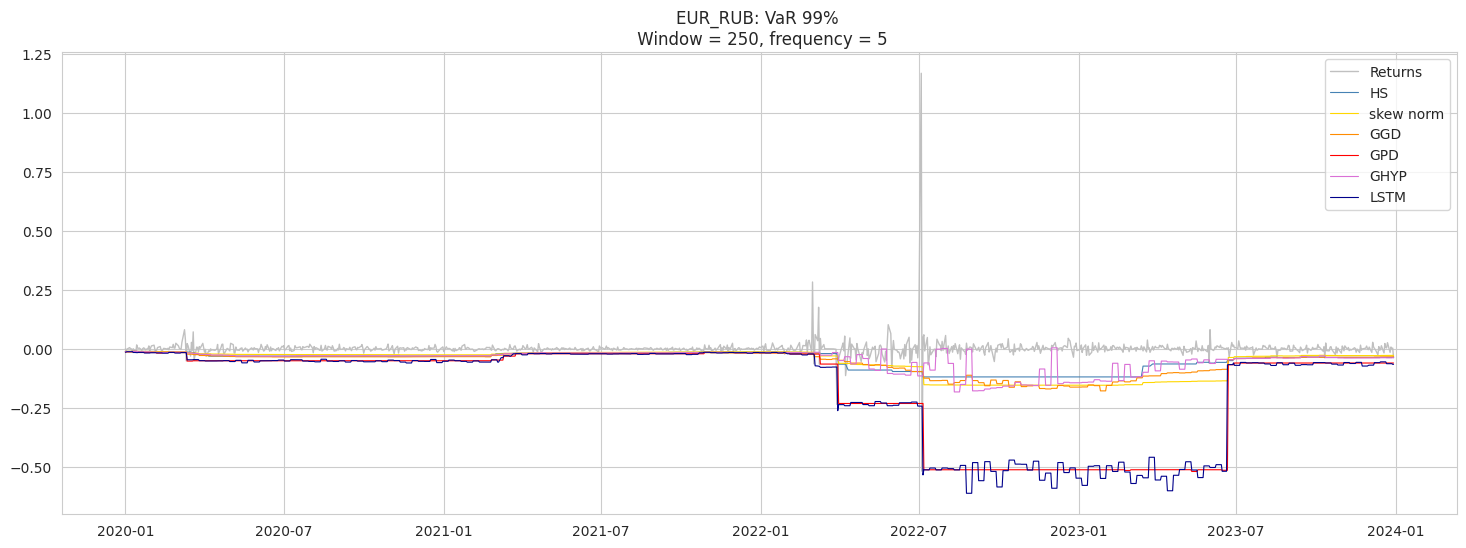

In [44]:
euro_res.plot_backtest(window=250, freq=5,
                       models=['HS', 'skew norm', 'GGD', 'GPD', 'GHYP', 'LSTM'],
                        start_date = '2020-01-01')

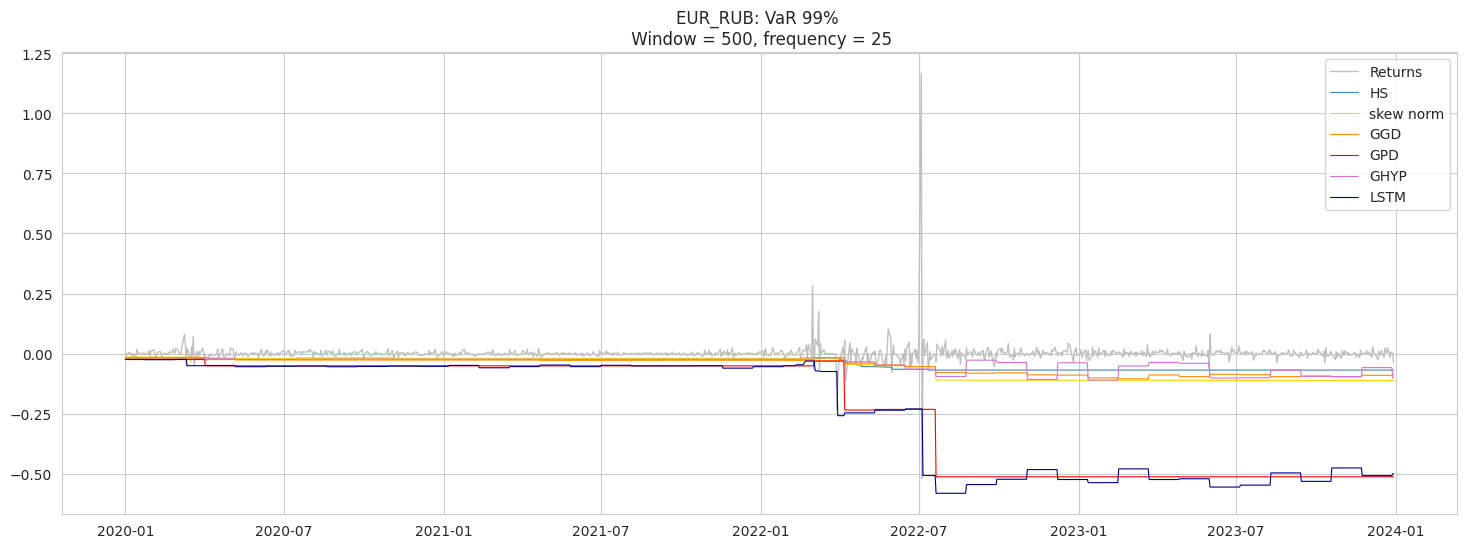

In [45]:
euro_res.plot_backtest(window=500, freq=25,
                       models=['HS', 'skew norm', 'GGD', 'GPD', 'GHYP', 'LSTM'],
                        start_date = '2020-01-01')

## IMOEX

In [ ]:
warnings.filterwarnings("ignore")

imoex = calculate_returns(df=df_price, name='IMOEX')
calculate_var(name='IMOEX', returns=imoex, file_name='final')

In [56]:
# Результаты вычисления VaR

df_imoex = download_data('IMOEX', file_name='var99 full')

In [57]:
imoex_res = VAR_visualisation(name='IMOEX', df_var=df_imoex)

#### Тесты

Тест Купика

In [58]:
imoex_res.test_kupiec(window=250, freq=50)

,Kupiec POF,p value,H0 принимается
Исторический метод,6.533184,0.01059,0.0
Нормальное распределение,8.327497,0.00390,0.0
Скошенное нормальное распределение,8.327497,0.00390,0.0
Обобщенное нормальное распределение,2.350325,0.12526,1.0
Распределение Стьюдента,51.931029,0.00000,0.0
Нецентральное распределение Стьюдента,51.931029,0.00000,0.0
Обобщенное Парето распределение,1.742437,0.18683,1.0
Обобщенное распределение экстремальных значений,0.498804,0.48003,1.0
Обобщенное гиперболическое распределение,1.841900,0.17473,1.0
LSTM,25.073376,0.00000,0.0


In [59]:
imoex_res.test_kupiec_all()

Тест Кристофферсена

In [60]:
imoex_res.test_christoffersen(window=500, freq=25)

,LR_ind,p value,H0 принимается
Исторический метод,4.613343,0.03172,0.0
Нормальное распределение,6.249280,0.01242,0.0
Скошенное нормальное распределение,5.948968,0.01473,0.0
Обобщенное нормальное распределение,3.339047,0.06765,1.0
Распределение Стьюдента,15.678217,0.00008,0.0
Нецентральное распределение Стьюдента,9.129685,0.00251,0.0
Обобщенное Парето распределение,0.012769,0.91003,1.0
Обобщенное распределение экстремальных значений,0.289846,0.59032,1.0
Обобщенное гиперболическое распределение,8.336990,0.00388,0.0
LSTM,0.007180,0.93247,1.0


In [61]:
imoex_res.test_christoffersen_all()

In [62]:
imoex_res.get_backtest_results()

Доля отклонений (%) 



Исторический метод  Нормальное распределение  \
Window Freq                                                 
250    25                  1.52                      1.63   
       50                  1.52                      1.59   
       75                  1.52                      1.63   
       100                 1.52                      1.67   
       150                 1.52                      1.59   
       200                 1.52                      1.67   
500    25                  1.63                      1.39   
       50                  1.63                      1.39   
       75                  1.63                      1.43   
       100                 1.63                      1.43   
       150                 1.63                      1.39   
       200                 1.63                      1.47   
750    25                  1.37                      1.55   
       50                  1.37                      1.55   
       75                  1.37                      1.50   
       100                 1.37                      1.55   
       150                 1.37                      1.50   
       200                 1.37                      1.50   
1000   25                  1.44                      1.69   
       50                  1.44                      1.69   
       75                  1.44                      1.69   
       100                 1.44                      1.69   
       150                 1.44                      1.69   
       200                 1.44                      1.69   
1250   25                  1.53                      1.93   
       50                  1.53                      1.93   
       75                  1.53                      1.93   
       100                 1.53                      1.93   
       150                 1.53                      1.93   
       200                 1.53                      1.93   

             Скошенное нормальное распределение  \
Window Freq                                       
250    25                                  1.59   
       50                                  1.59   
       75                                  1.59   
       100                                 1.63   
       150                                 1.56   
       200                                 1.63   
500    25                                  1.43   
       50                                  1.35   
       75                                  1.43   
       100                                 1.35   
       150                                 1.39   
       200                                 1.39   
750    25                                  1.37   
       50                                  1.42   
       75                                  1.42   
       100                                 1.42   
       150                                 1.42   
       200                                 1.42   
1000   25                                  1.49   
       50                                  1.49   
       75                                  1.54   
       100                                 1.54   
       150                                 1.54   
       200                                 1.54   
1250   25                                  1.82   
       50                                  1.82   
       75                                  1.76   
       100                                 1.82   
       150                                 1.82   
       200                                 1.82   

             Обобщенное нормальное распределение  Распределение Стьюдента  \
Window Freq                                                                 
250    25                                   1.30                     2.68   
       50                                   1.30                     2.64   
       75                                   1.34                     2.68   
       100                                

#### Результаты

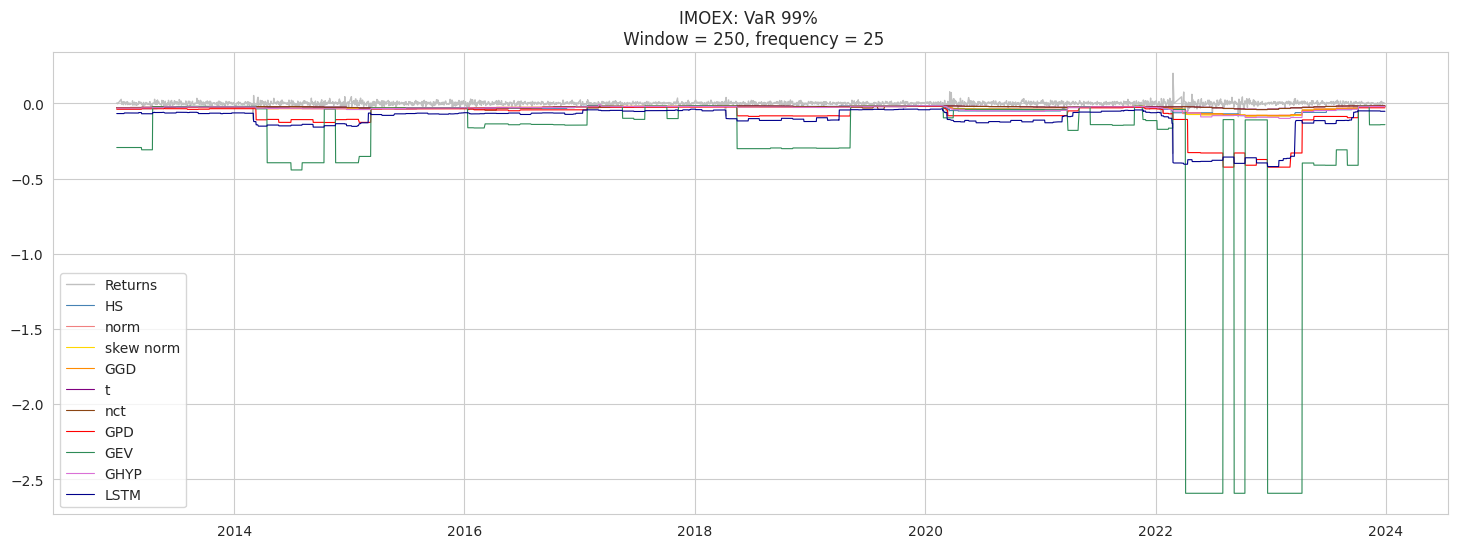

In [65]:
imoex_res.plot_backtest(window=250, freq=25)

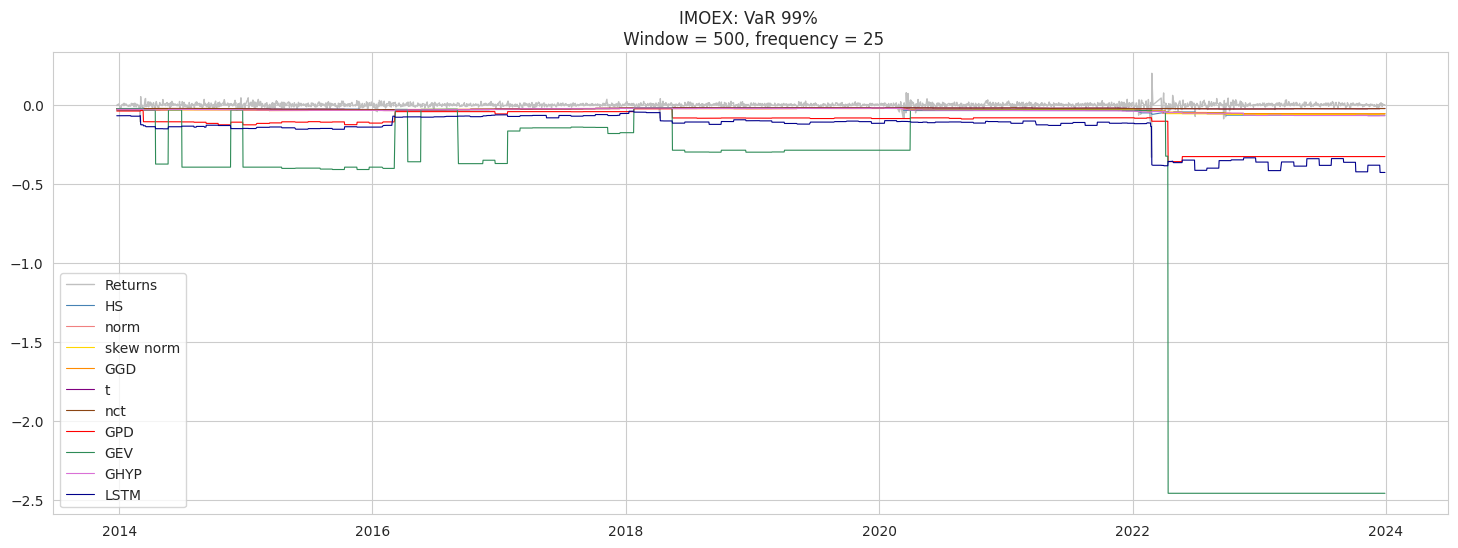

In [66]:
imoex_res.plot_backtest(window=500, freq=25)

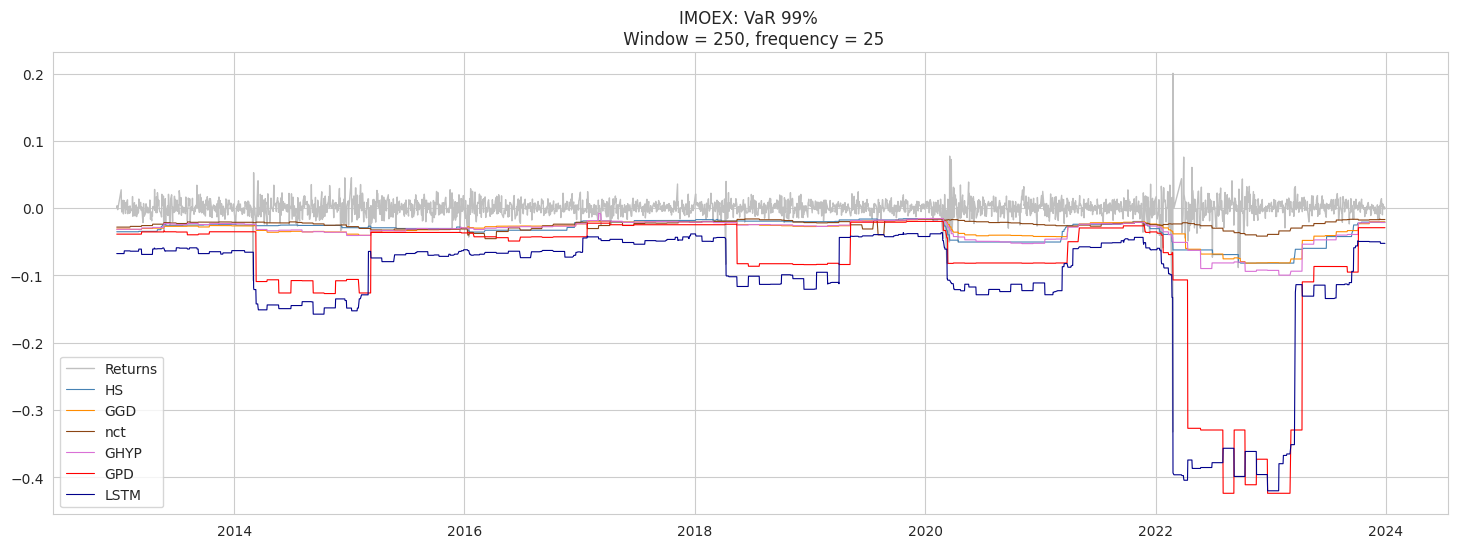

In [70]:
imoex_res.plot_backtest(window=250, freq=25, models=['HS', 'GGD', 'nct', 'GHYP', 'GPD', 'LSTM'])

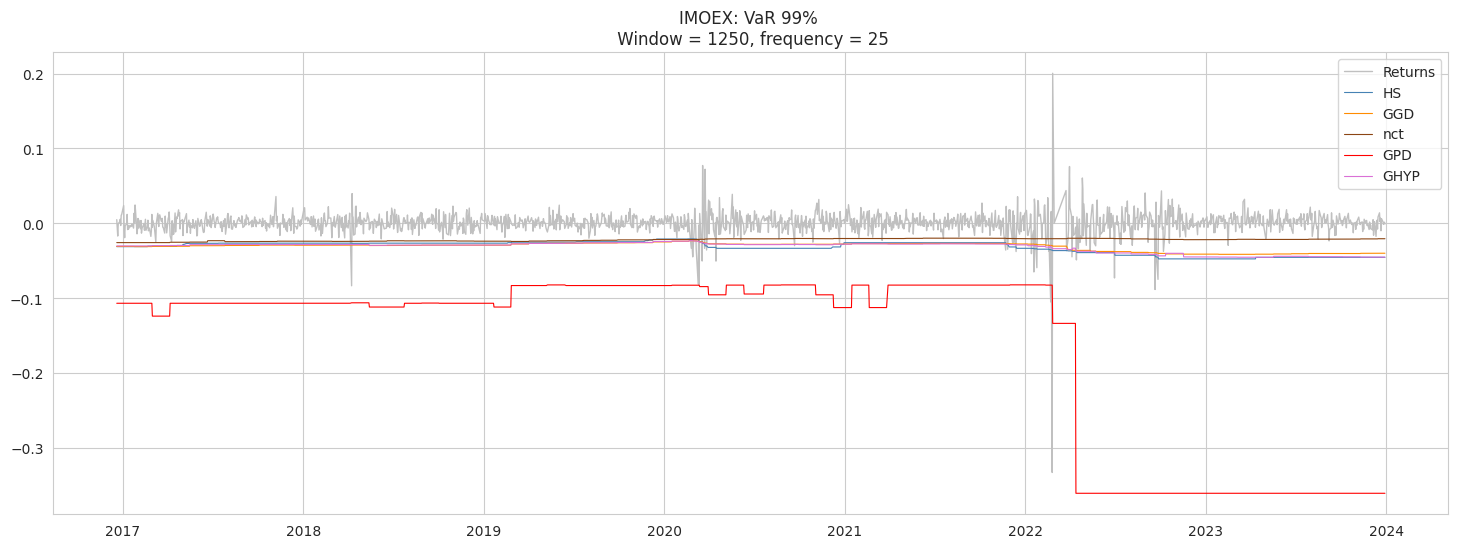

In [72]:
imoex_res.plot_backtest(window=1250, freq=25, models=['HS', 'GGD', 'nct', 'GPD', 'GHYP'])

#### Параметры

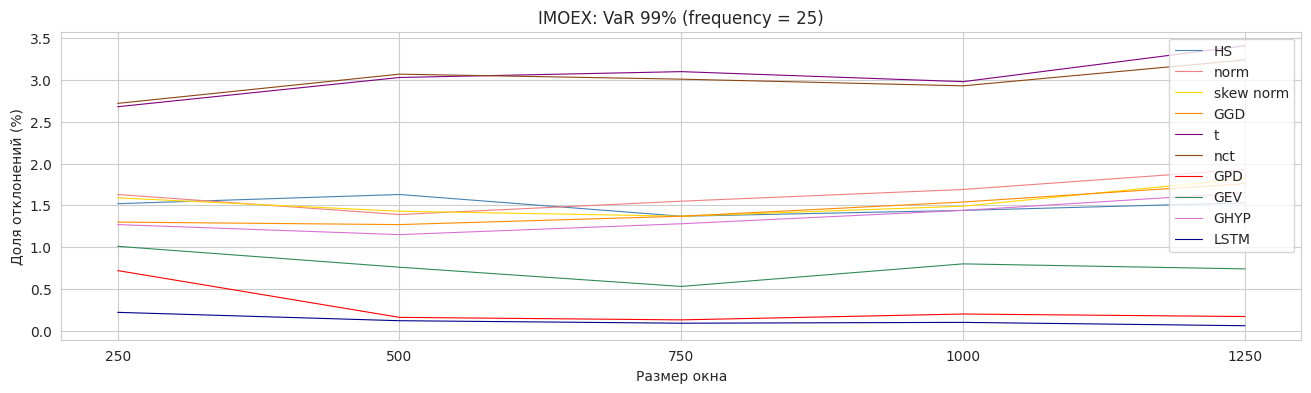

In [73]:
imoex_res.plot_parametr_window(freq=25)

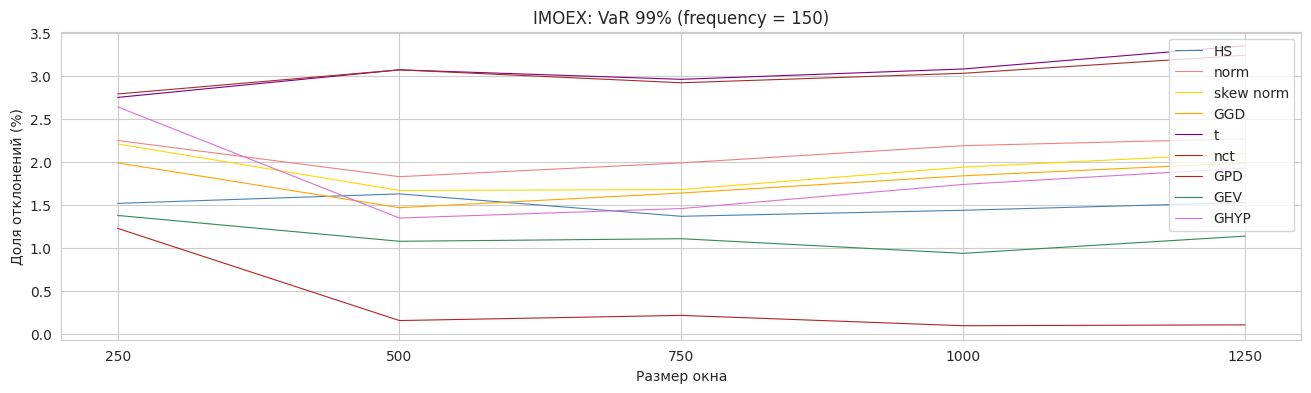

In [ ]:
imoex_res.plot_parametr_window(freq=150)

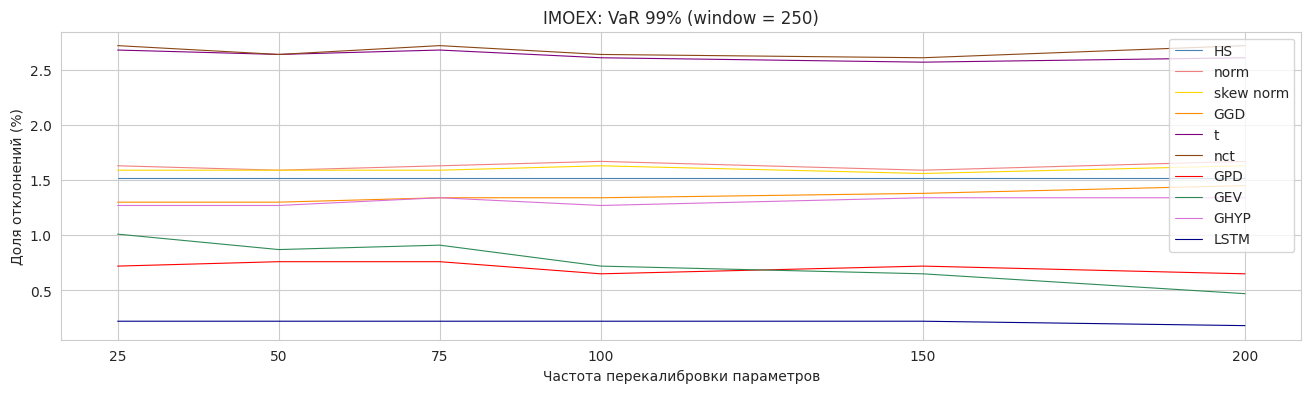

In [74]:
imoex_res.plot_parametr_frequency(window=250)

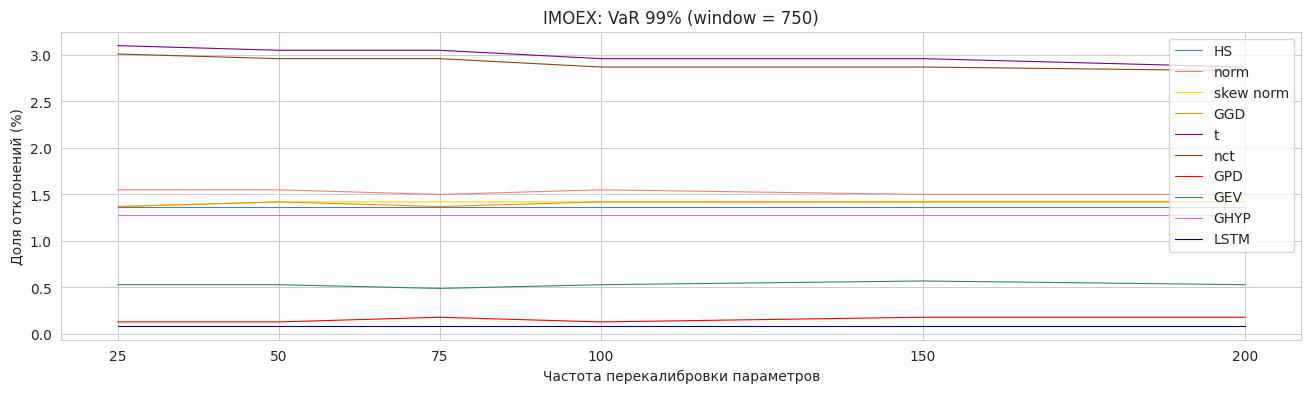

In [76]:
imoex_res.plot_parametr_frequency(window=750)

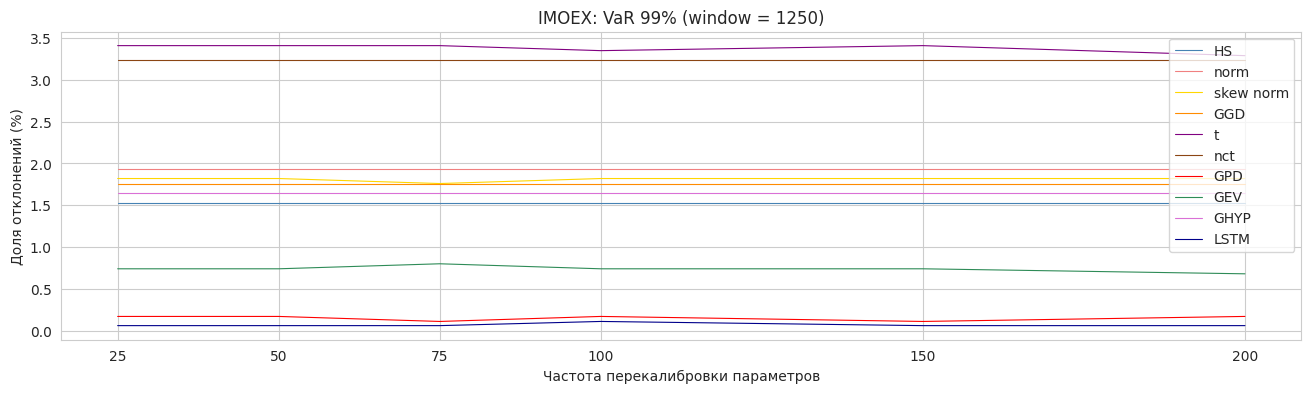

In [75]:
imoex_res.plot_parametr_frequency(window=1250)